In [1]:
!pip install pytorch-forecasting

In [2]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-c4ctotxj
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-c4ctotxj
  Running command git submodule update --init --recursive -q
  From https://github.com/PyTorchLightning/lightning-tutorials
   * branch            290fb466de1fcc2ac6025f74b56906592911e856 -> FETCH_HEAD
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd

matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['axes.grid'] = False
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# from pytorch_forecasting.metrics import MAPE
import torch

seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
# Loss function
def mape(y_pred, y_train):
    ape = np.abs((y_pred - y_train) / y_train)
    ape[~np.isfinite(ape)] = 1
    return np.mean(ape)

In [22]:
df = pd.read_excel('/content/Train_data.xlsx')
df["2021-06-01 00:00:00"] = 0
# print(df)
# df.drop(datetime(2020,4,1,0,0), axis=1, inplace=True)
df = df.melt(id_vars=['Warehouse id', 'Region', 'SKU id'], var_name='date', value_name='sales')
# df['SKU id'] = df['SKU id'].str.extract('(\d+)',expand = False).astype(int)
# df.rename(columns={'SKU id':'store_id'}, inplace=True)
# df.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """


In [23]:
# # Region-wise split of dataset
# df_N = df[df['Region'] == 'NORTH'].drop(['Warehouse id', 'Region'], axis=1).reset_index(drop=True)
# df_S = df[df['Region'] == 'SOUTH'].drop(['Warehouse id', 'Region'], axis=1).reset_index(drop=True)
# df_E = df[df['Region'] == 'EAST'].drop(['Warehouse id', 'Region'], axis=1).reset_index(drop=True)
# df_W = df[df['Region'] == 'WEST'].drop(['Warehouse id', 'Region'], axis=1).reset_index(drop=True)

# df_N = df_N.pivot('date', 'SKU id', 'sales')
# df_S = df_S.pivot('date', 'SKU id', 'sales')
# df_E = df_E.pivot('date', 'SKU id', 'sales')
# df_W = df_W.pivot('date', 'SKU id', 'sales')

In [24]:
# Feature Engineering
df['sales previous month'] = df.groupby(['Region', 'SKU id'])['sales'].shift(1)
# df['sales next month'] = df.groupby(['Region', 'SKU id'])['sales'].shift(-1)
# df['diff sales 1'] = df.groupby(['Region', 'SKU id'])['sales'].diff(1)
df.sort_values(['Region', 'SKU id', 'date'], inplace=True)
# df['rolling mean sales 4'] = df.groupby(['Warehouse id', 'SKU id'])['sales'].rolling(4).mean().reset_index(level=0, drop=True).reset_index(level=0, drop=True)
# df['exp mean'] = df.groupby(['Warehouse id', 'SKU id'])['sales'].ewm(alpha=0.2).mean().reset_index(level=0, drop=True).reset_index(level=0, drop=True)

df['isHoli'] = df['date'].apply(lambda x: x.month == 3).astype(int)
df['isDiwali'] = df['date'].apply(lambda x: x.month == 10).astype(int)
df['isSankranti'] = df['date'].apply(lambda x: x.month == 1).astype(int)
df['isChristmas'] = df['date'].apply(lambda x: x.month == 12).astype(int)
df['isSummer'] = df['date'].apply(lambda x: x.month == 4 or x.month == 5 or x.month == 6).astype(int)
df['isWinter'] = df['date'].apply(lambda x: x.month == 11 or x.month == 12 or x.month == 1 or x.month == 2).astype(int)

df['isHoli'] = df['isHoli'].astype(str).astype("category")
df['isDiwali'] = df['isDiwali'].astype(str).astype("category")
df['isSankranti'] = df['isSankranti'].astype(str).astype("category")
df['isChristmas'] = df['isChristmas'].astype(str).astype("category")
df['isSummer'] = df.isSummer.astype(str).astype("category")
df['isWinter'] = df.isWinter.astype(str).astype("category")
# Add 2020 Aug, Sep, Oct and 2021 Mar, Apr, May to this
df['isCovid'] = df['date'].apply(lambda x: (x.year == 2020 and (x.month == 8 or x.month == 9 or x.month == 10) or (x.year == 2021 and (x.month == 3 or x.month == 4 or x.month == 5 or x.month == 6)))).astype(int)
df['isCovid'] = df.isCovid.astype(str).astype("category")

df["month"] = df.date.dt.month.astype(str).astype("category")

df.sort_values(['Warehouse id', 'SKU id', 'date'], inplace=True)

df["time_idx"] = df["date"].dt.year * 12 + df["date"].dt.month
df["time_idx"] -= df["time_idx"].min()

# df['Avg sales by SKU'] = df.groupby(["time_idx", "SKU id"], observed=True).sales.transform("mean")
# df['Avg sales by Warehouse'] = df.groupby(["time_idx", "Warehouse id"], observed=True).sales.transform("mean")

df.reset_index(level=0, drop=True, inplace=True)
df.fillna(df.median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [25]:
df.tail()

,Warehouse id,Region,SKU id,date,sales,sales previous month,isHoli,isDiwali,isSankranti,isChristmas,isSummer,isWinter,isCovid,month,time_idx
40516,Wh-4,SOUTH,SKU-98,2021-02-01,196,184.0,0,0,0,0,0,1,0,2,34
40517,Wh-4,SOUTH,SKU-98,2021-03-01,210,196.0,1,0,0,0,0,0,1,3,35
40518,Wh-4,SOUTH,SKU-98,2021-04-01,116,210.0,0,0,0,0,1,0,1,4,36
40519,Wh-4,SOUTH,SKU-98,2021-05-01,12,116.0,0,0,0,0,1,0,1,5,37
40520,Wh-4,SOUTH,SKU-98,2021-06-01,0,12.0,0,0,0,0,1,0,1,6,38


In [26]:
test_df = df[df['date'] == '2021-06-01'].reset_index(drop=True)
test_df

,Warehouse id,Region,SKU id,date,sales,sales previous month,isHoli,isDiwali,isSankranti,isChristmas,isSummer,isWinter,isCovid,month,time_idx
0,Wh-1,NORTH,SKU-1,2021-06-01,0,12.0,0,0,0,0,1,0,1,6,38
1,Wh-1,NORTH,SKU-10,2021-06-01,0,40.0,0,0,0,0,1,0,1,6,38
2,Wh-1,NORTH,SKU-100,2021-06-01,0,11.0,0,0,0,0,1,0,1,6,38
3,Wh-1,NORTH,SKU-101,2021-06-01,0,14.0,0,0,0,0,1,0,1,6,38
4,Wh-1,NORTH,SKU-102,2021-06-01,0,25.0,0,0,0,0,1,0,1,6,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,Wh-4,SOUTH,SKU-92,2021-06-01,0,1.0,0,0,0,0,1,0,1,6,38
1035,Wh-4,SOUTH,SKU-93,2021-06-01,0,16.0,0,0,0,0,1,0,1,6,38
1036,Wh-4,SOUTH,SKU-95,2021-06-01,0,9.0,0,0,0,0,1,0,1,6,38
1037,Wh-4,SOUTH,SKU-97,2021-06-01,0,12.0,0,0,0,0,1,0,1,6,38


In [27]:
from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)

In [28]:
max_prediction_length = 7 # forecast 6 months
max_encoder_length = 39  # use 39 months of history
training_cutoff = df["time_idx"].max() - max_prediction_length

In [29]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["Warehouse id", "SKU id", 'Region'],
    min_encoder_length=0,  # allow predictions without history
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Warehouse id", "SKU id", 'Region'],
    static_reals=[],
    time_varying_known_categoricals=['isHoli', 'isDiwali', 'isSankranti', 'isChristmas', "month", "isCovid"],
    # group of categorical variables can be treated as 
    # one variable
    variable_groups={"special_months": ['isHoli', 'isDiwali', 'isSankranti', 'isChristmas', 'isCovid']},
    time_varying_known_reals=[
        "time_idx"
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "sales",
        "sales previous month",
        # "sales next month",
        # "diff sales 1",
        # "rolling mean sales 4",
        # "Avg sales by SKU",
        # "Avg sales by Warehouse"
    ],
    target_normalizer=GroupNormalizer(
        groups=["Warehouse id", "SKU id", "Region"]
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
    allow_missing_timesteps=True
)
# create validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(
    training, df, predict=True, stop_randomization=True
)
# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)


/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:621: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1780: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1890: PossibleUserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:722: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:781: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:781: RuntimeWarning: More than 20 figures hav

suggested learning rate: 8.79126813345522e-07


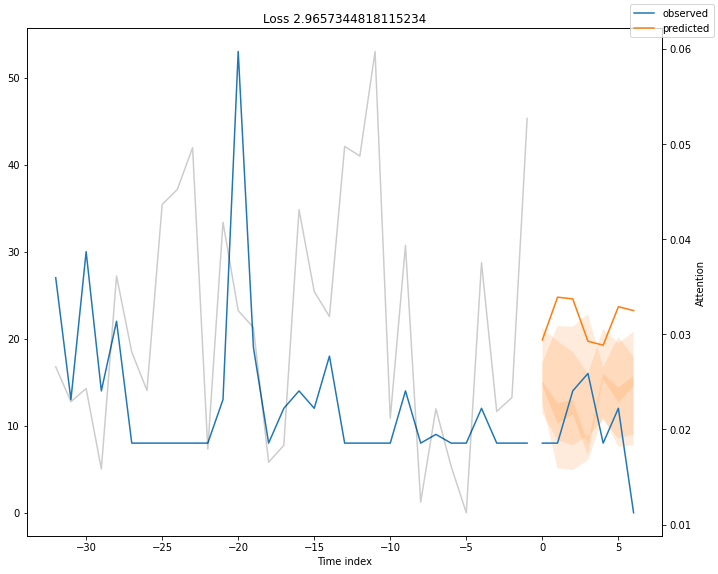

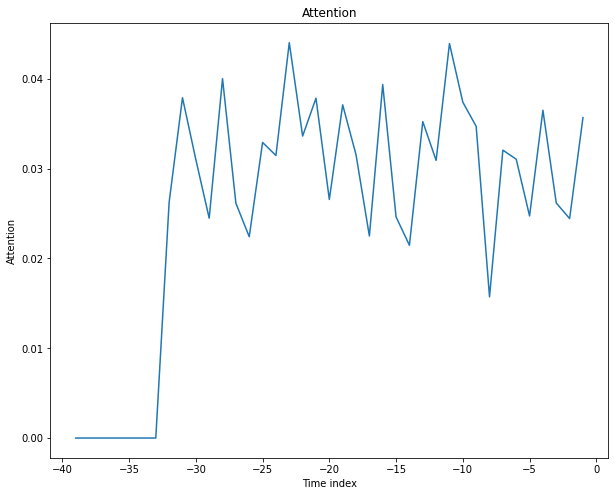

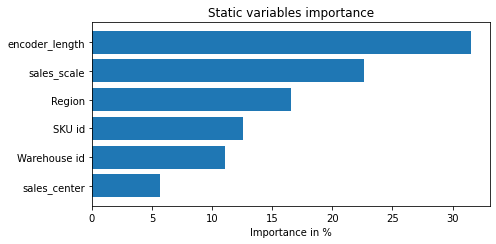

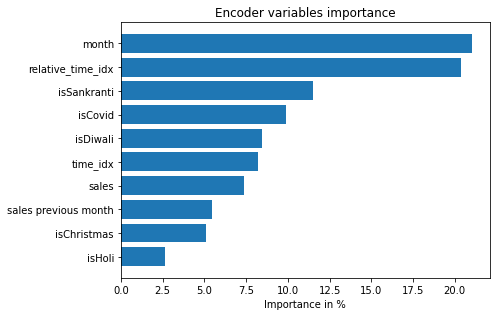

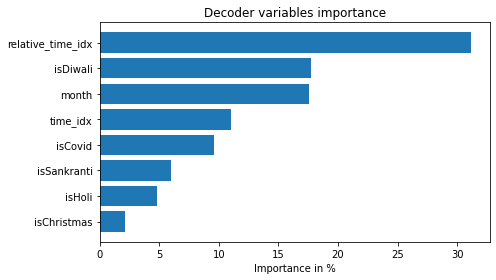

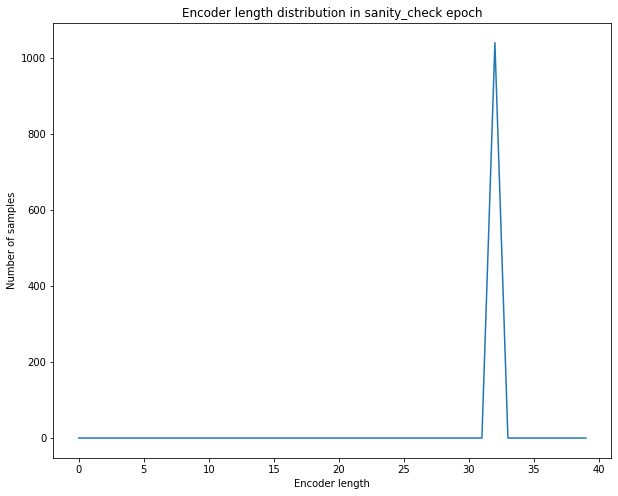

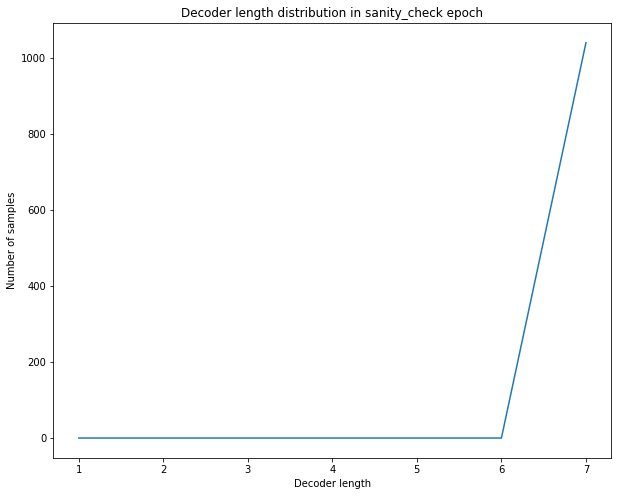

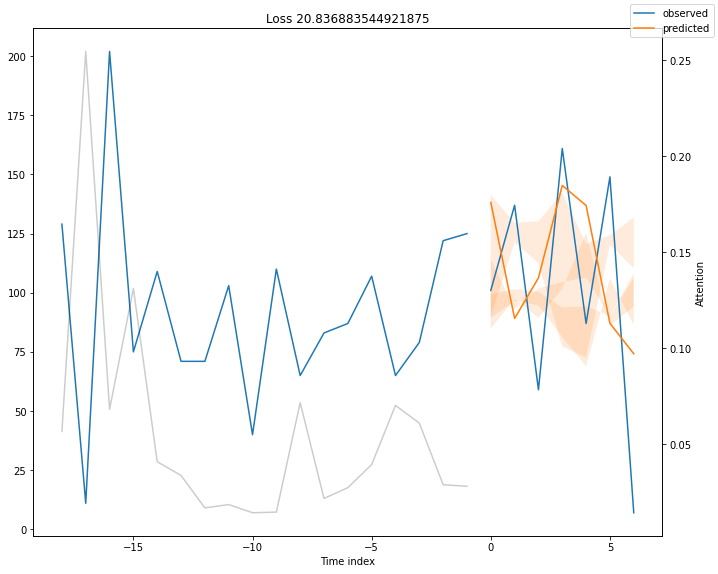

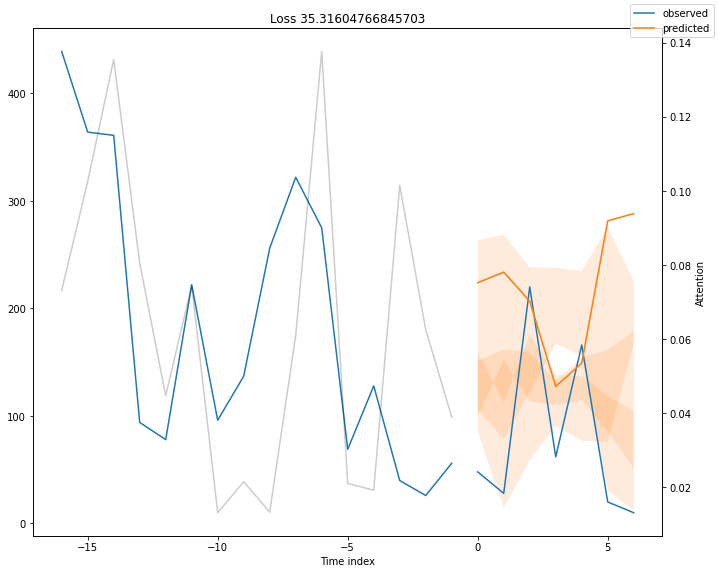

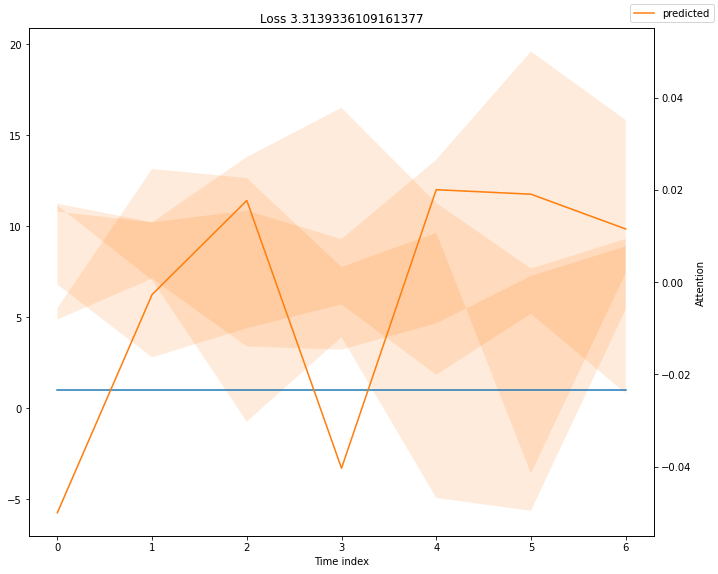

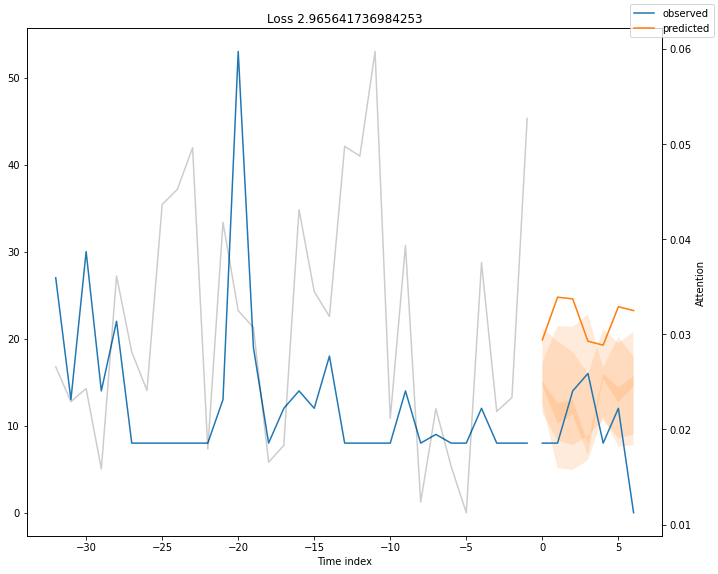

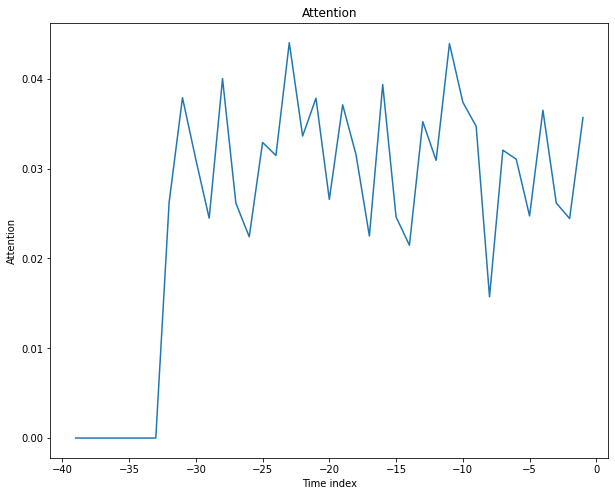

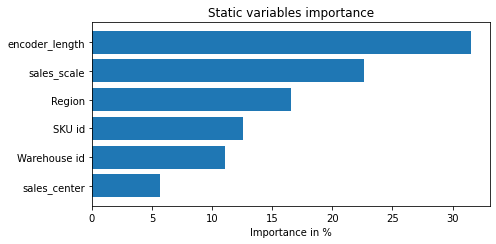

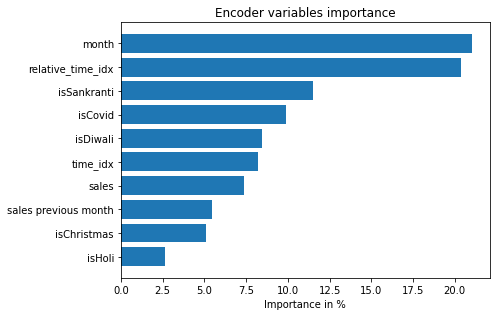

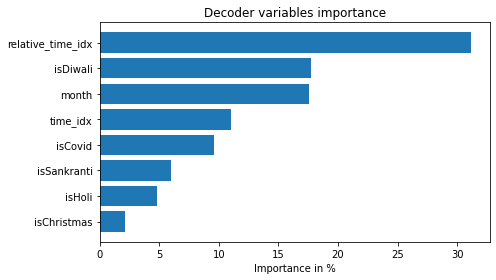

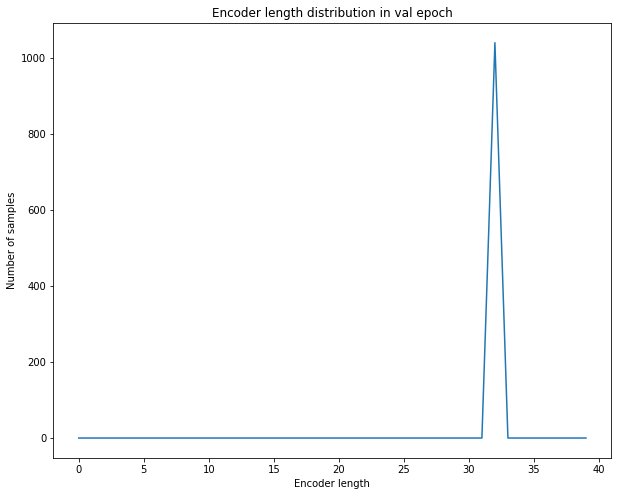

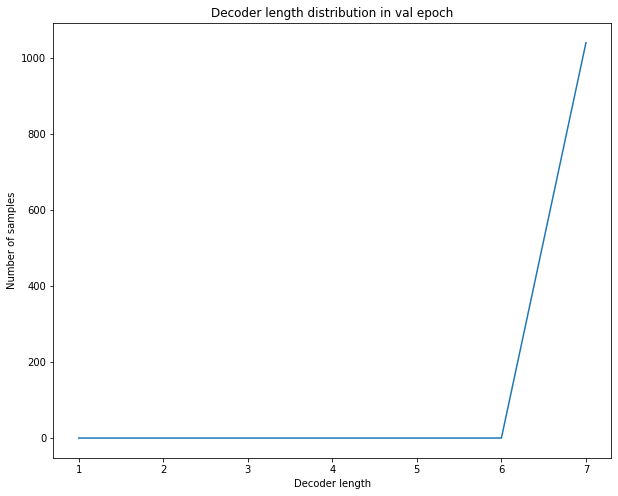

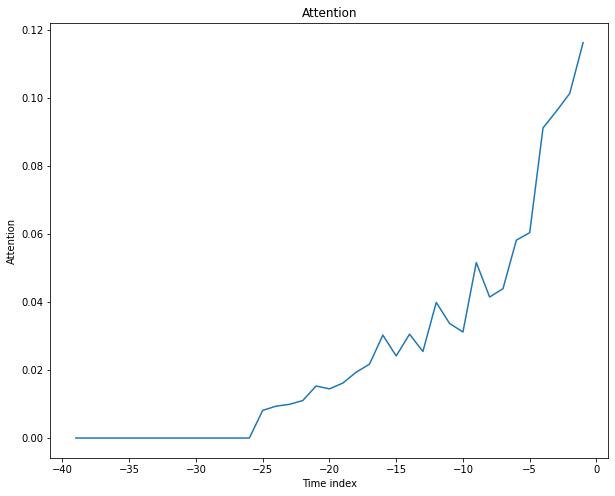

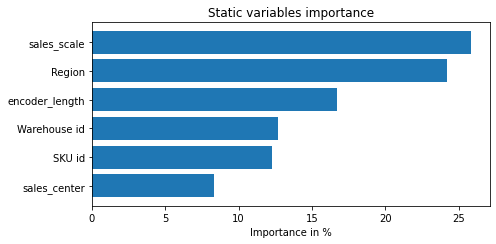

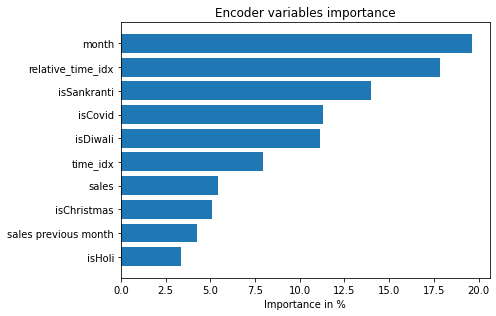

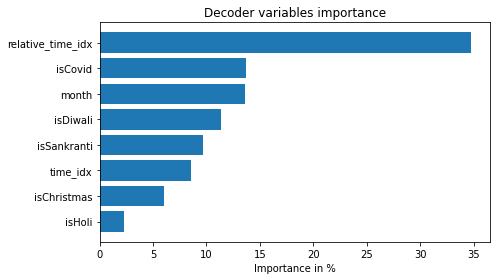

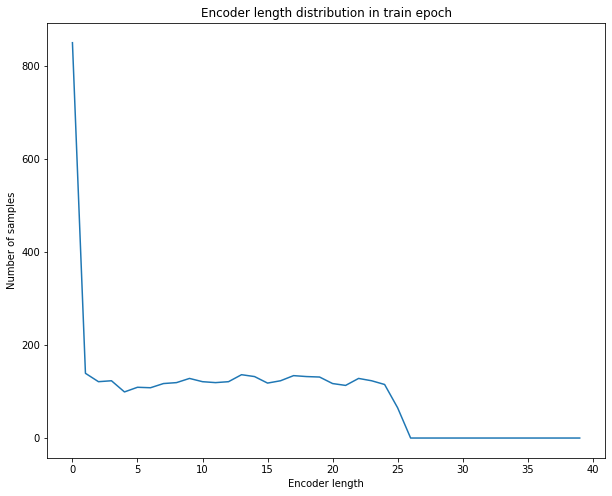

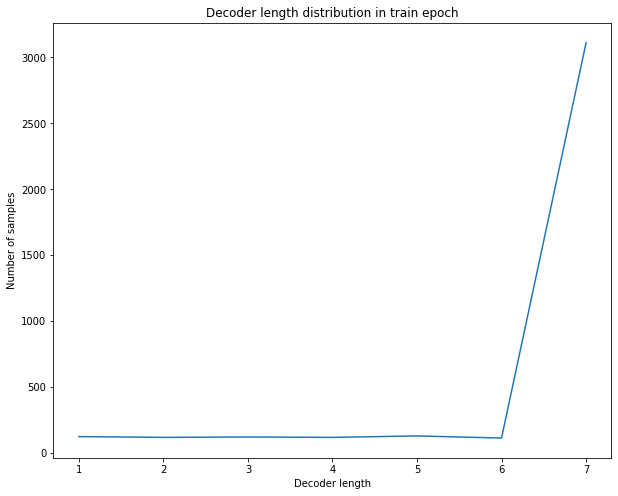

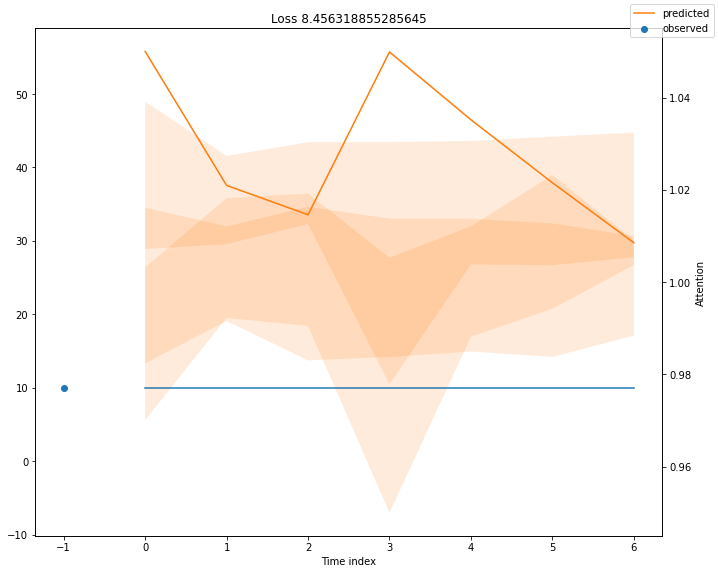

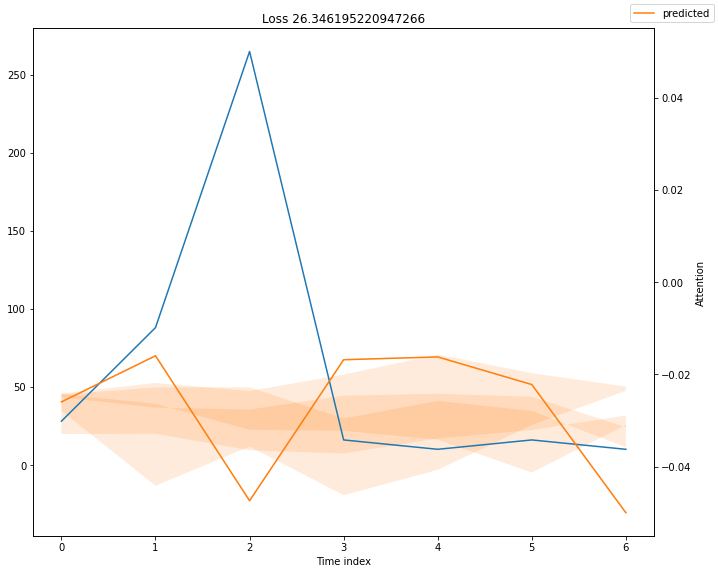

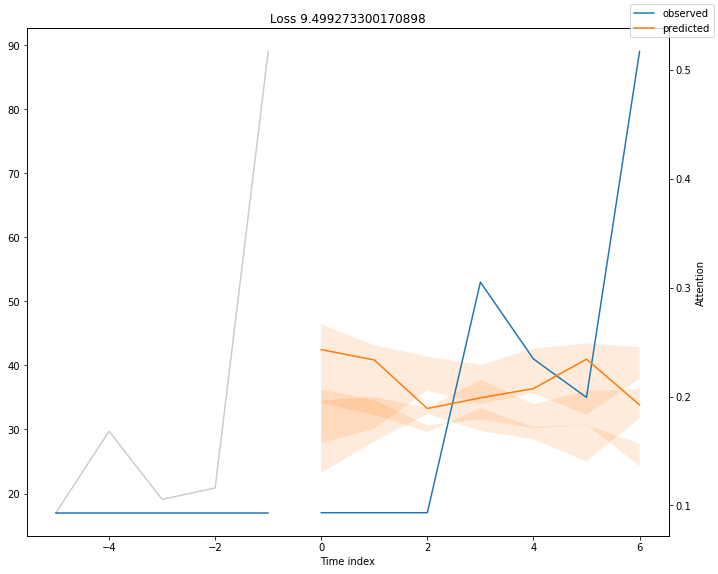

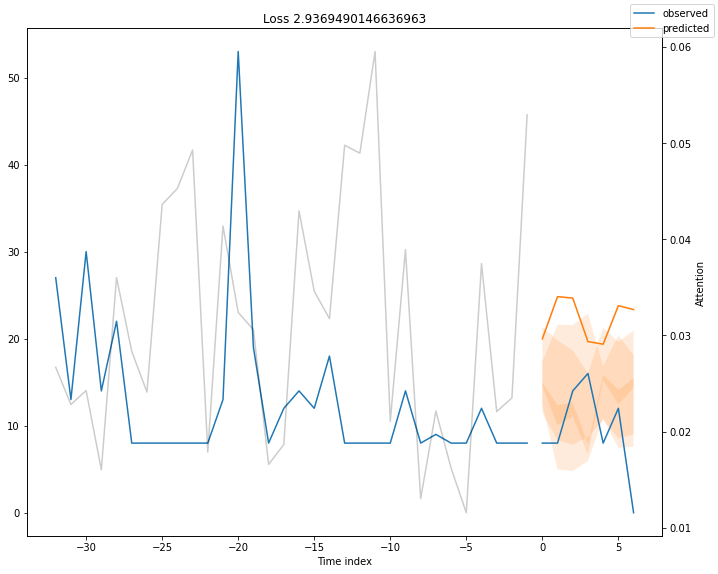

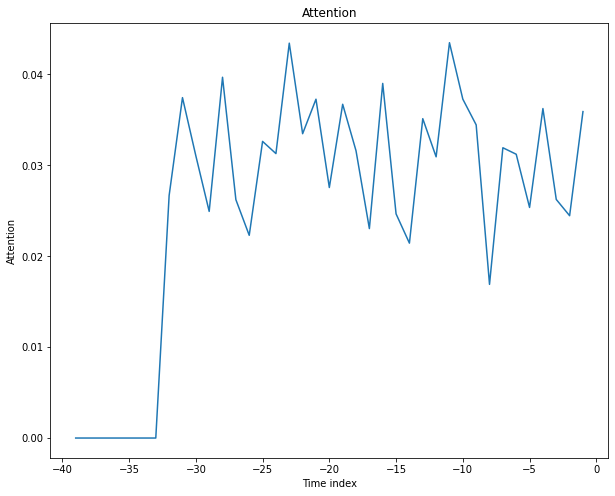

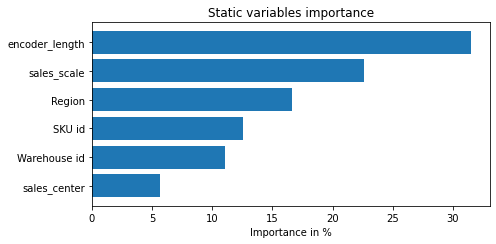

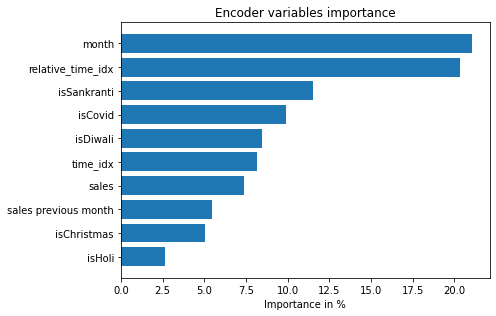

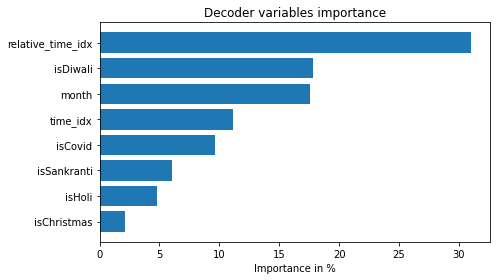

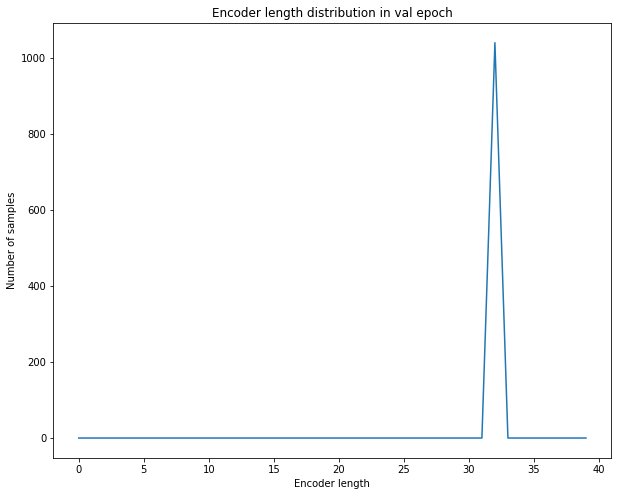

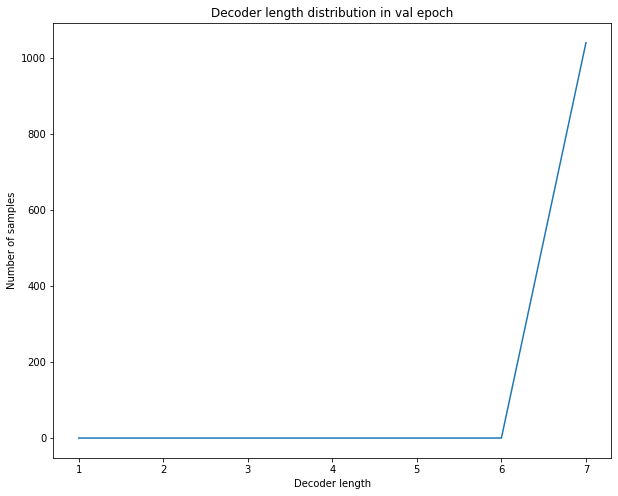

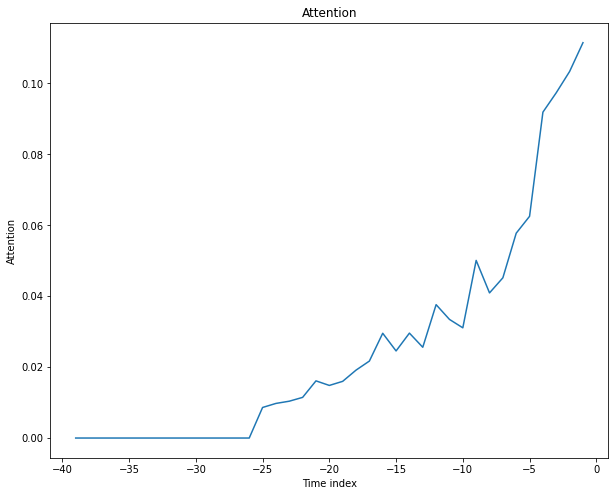

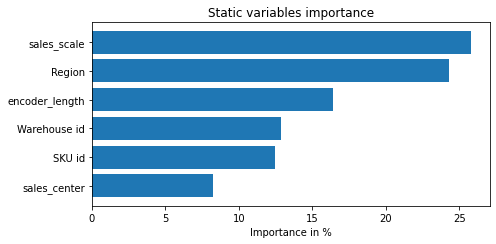

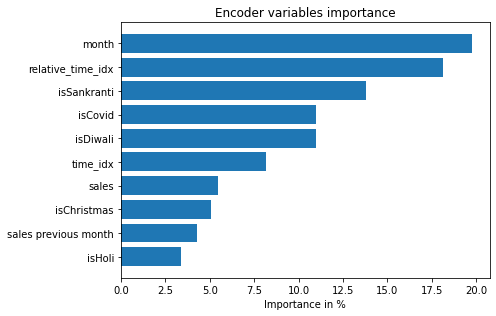

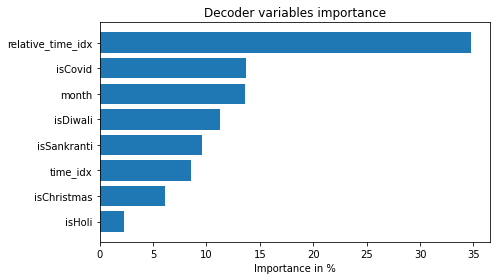

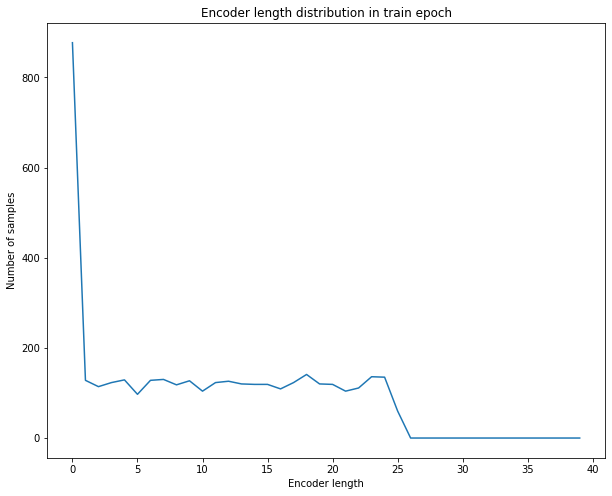

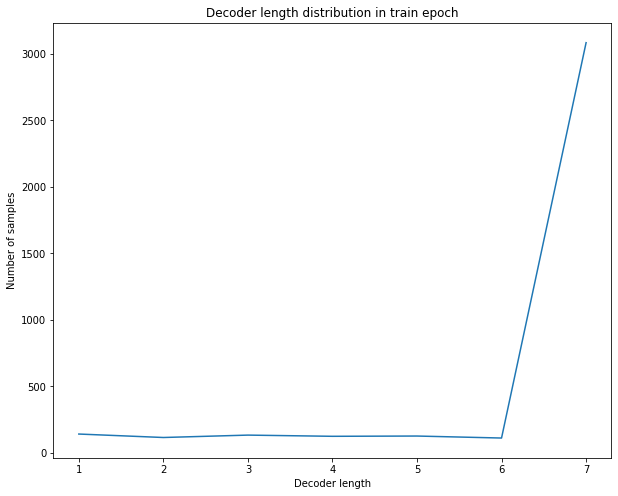

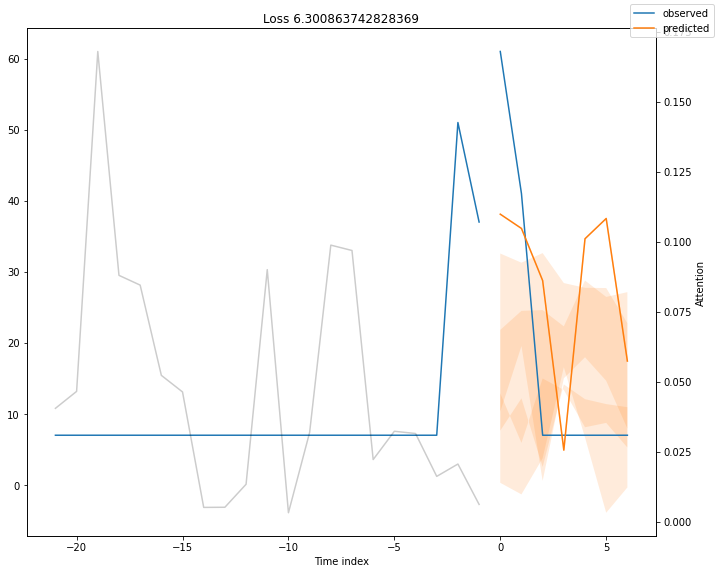

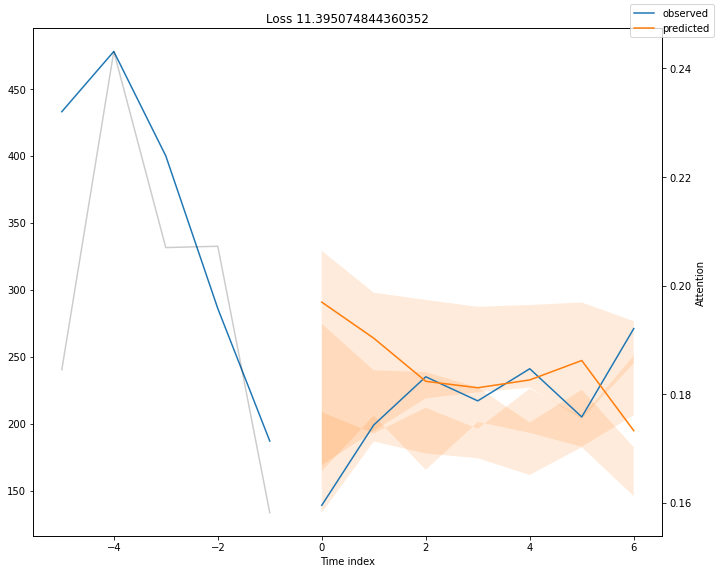

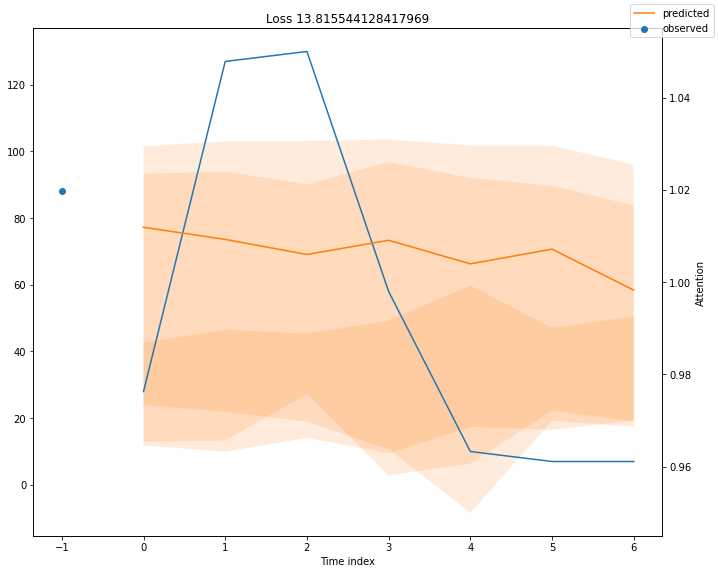

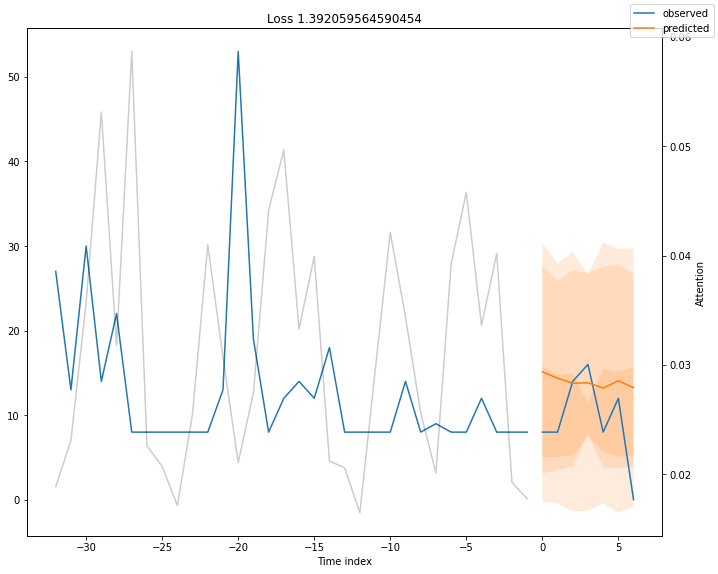

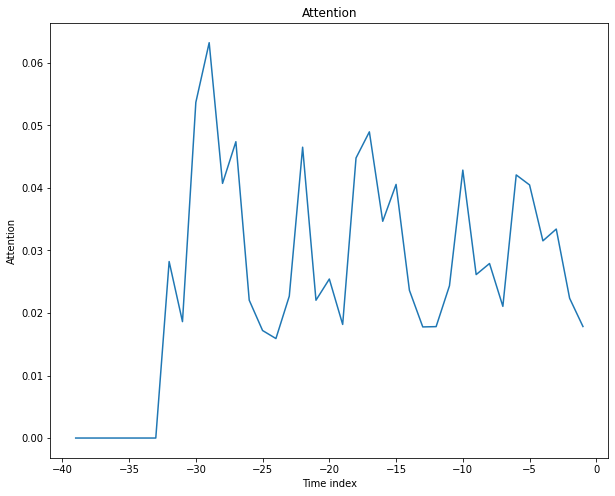

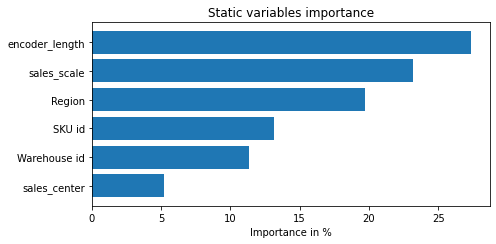

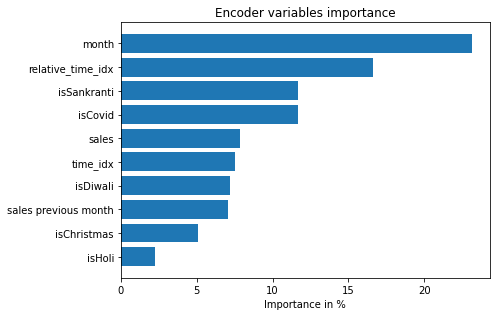

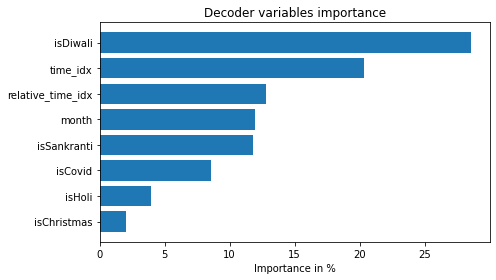

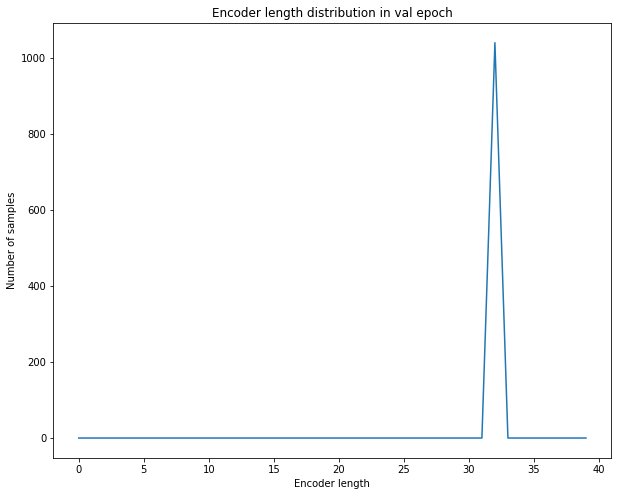

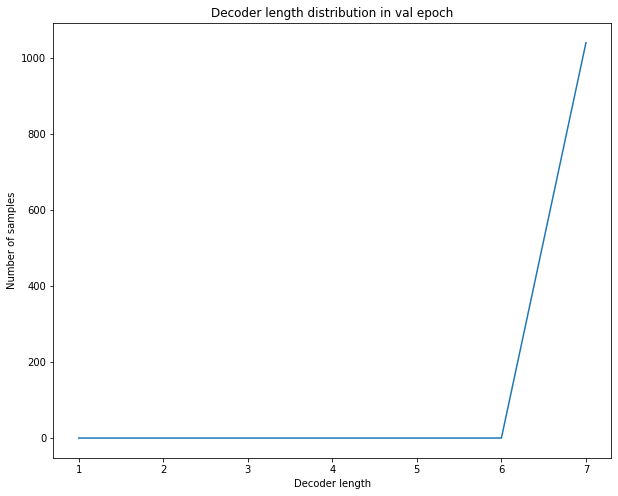

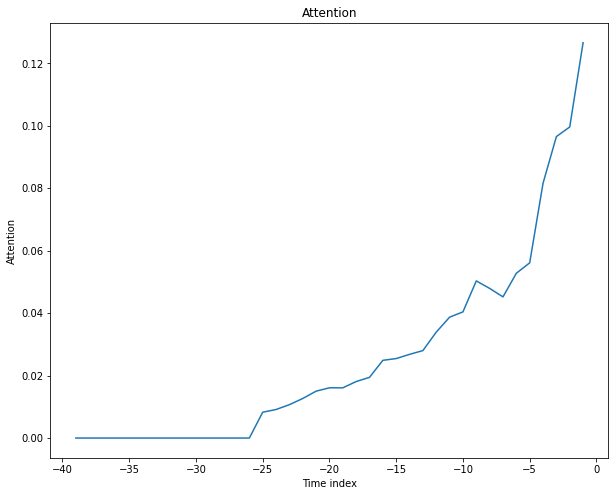

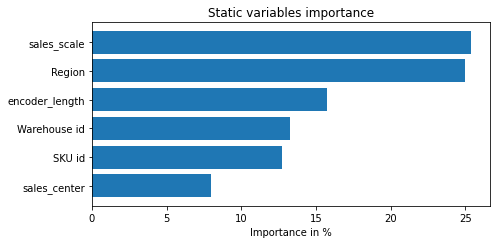

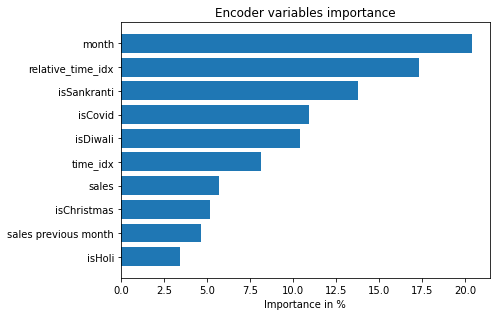

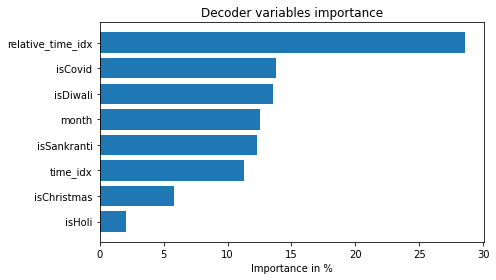

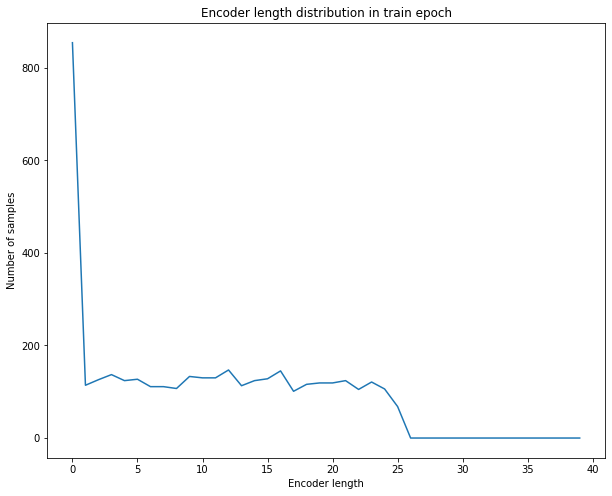

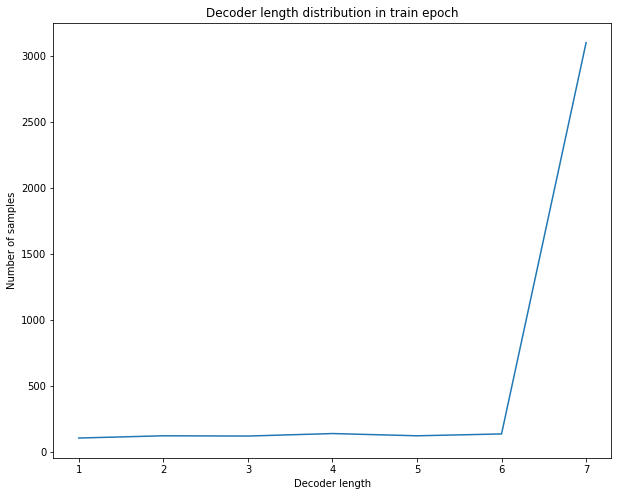

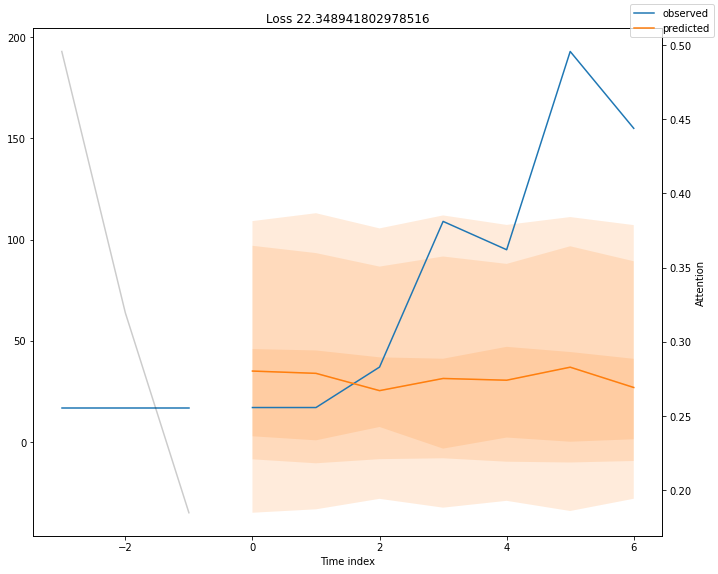

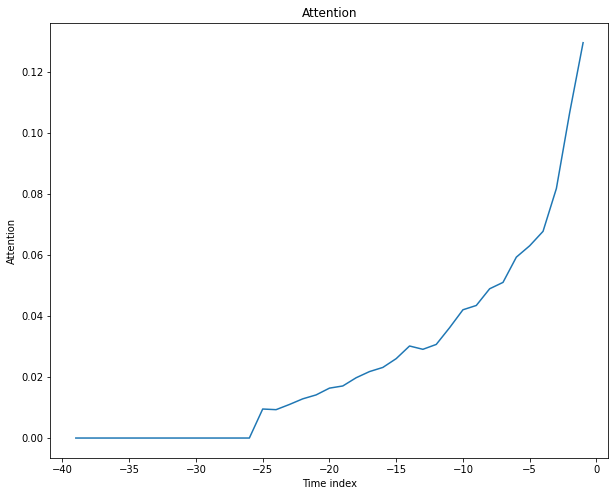

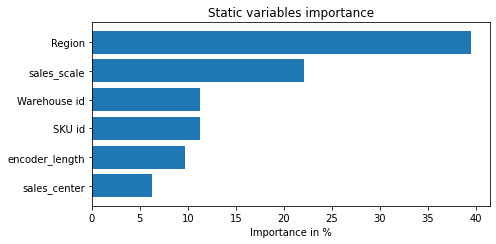

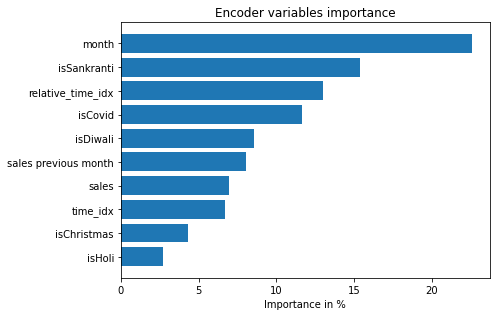

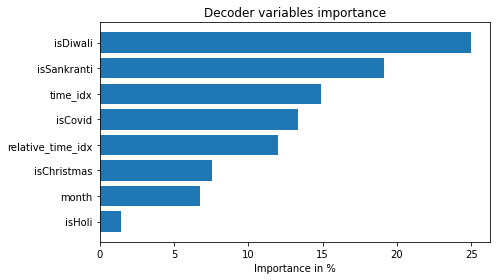

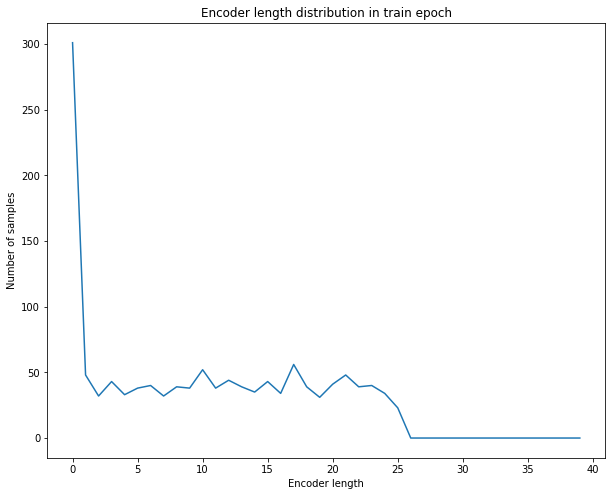

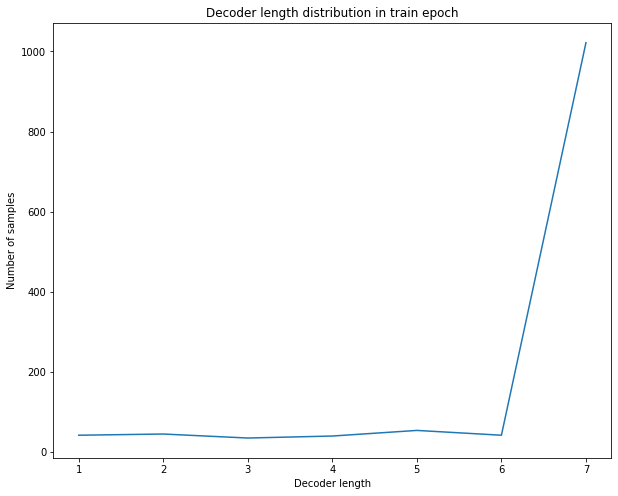

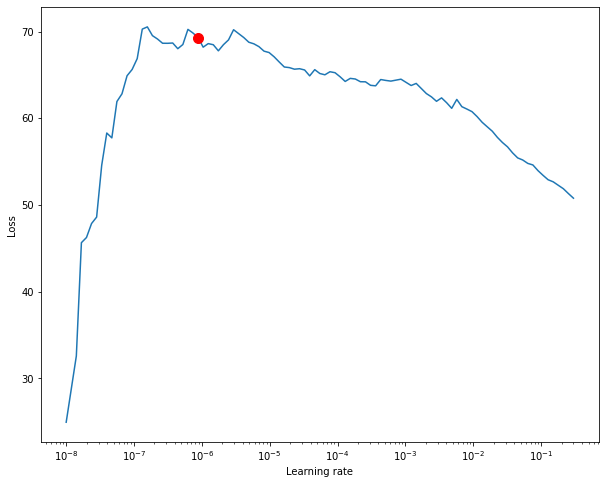


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 8.7 K 
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.9 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.9 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.9 

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1890: PossibleUserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [30]:
# imports for training
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss

lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # log to tensorboard
# create trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,  # train on CPU, use gpus = [0] to run on GPU
    gradient_clip_val=0.1,
    limit_train_batches=30,  # running validation every 30 batches
    # fast_dev_run=True,  # comment in to quickly check for bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)
# initialise model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=21,  # biggest influence network size
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # log example every 10 batches
    reduce_on_plateau_patience=4,  # reduce learning automatically
)

res = trainer.tuner.lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

In [31]:
# load the best model according to the validation loss (given that
# we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

print(predictions.shape)
print(mape(predictions[:,0].cpu().detach().numpy(), actuals[:,0].cpu().detach().numpy()))
print(mape(predictions[:,1].cpu().detach().numpy(), actuals[:,1].cpu().detach().numpy()))
print(mape(predictions[:,2].cpu().detach().numpy(), actuals[:,2].cpu().detach().numpy()))
print(mape(predictions[:,3].cpu().detach().numpy(), actuals[:,3].cpu().detach().numpy()))
print(mape(predictions[:,4].cpu().detach().numpy(), actuals[:,4].cpu().detach().numpy()))
print(mape(predictions[:,5].cpu().detach().numpy(), actuals[:,5].cpu().detach().numpy()))
#print(mape(predictions[:,3].cpu().detach().numpy(), actuals[:,3].cpu().detach().numpy()))

torch.Size([1039, 7])
1.7576307
2.3169394
1.6684638
1.7955621
8.516816
5.645166


In [34]:
pred = pd.DataFrame()
actual = pd.DataFrame()
for i in range(6):
    pred = pd.concat([pred, pd.DataFrame(predictions[:, i].cpu().detach().numpy())], axis=0)
    actual = pd.concat([actual, pd.DataFrame(actuals[:, i].cpu().detach().numpy())], axis=0)

print(mape(pred, actual).astype(float))

0    3.616768
dtype: float64


In [35]:
test_df['pred'] = predictions[:,6].cpu().detach().numpy().astype(int)

In [36]:
test_df = test_df[['Warehouse id', 'Region', 'SKU id', 'pred']]

In [37]:
test_df

,Warehouse id,Region,SKU id,pred
0,Wh-1,NORTH,SKU-1,13
1,Wh-1,NORTH,SKU-10,161
2,Wh-1,NORTH,SKU-100,140
3,Wh-1,NORTH,SKU-101,20
4,Wh-1,NORTH,SKU-102,20
...,...,...,...,...
1034,Wh-4,SOUTH,SKU-92,31
1035,Wh-4,SOUTH,SKU-93,98
1036,Wh-4,SOUTH,SKU-95,24
1037,Wh-4,SOUTH,SKU-97,535


In [38]:
test_df.to_csv("june_DeepAR.csv")